<a href="https://colab.research.google.com/github/BeytullahYayla/Computer-Vision-For-Self-Driving-Cars/blob/main/Classifying%20Road%20Symbols/Classifying_Road_Symbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Required Libraires

In [98]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random 
np.random.seed(0)

## Download German-Traffic-Dataset
### About Dataset


In [99]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [100]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [101]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  valid_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)

In [103]:
print(type(train_data))
X_train,y_train=train_data["features"],train_data["labels"]
X_val,y_val=valid_data["features"],valid_data["labels"]
X_test,y_test=test_data["features"],test_data["labels"]

<class 'dict'>


In [104]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [105]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]),"The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]),"The number of images is not equal to the number of labels"
assert(X_train.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"


In [106]:
data=pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


## Visualizing Dataset

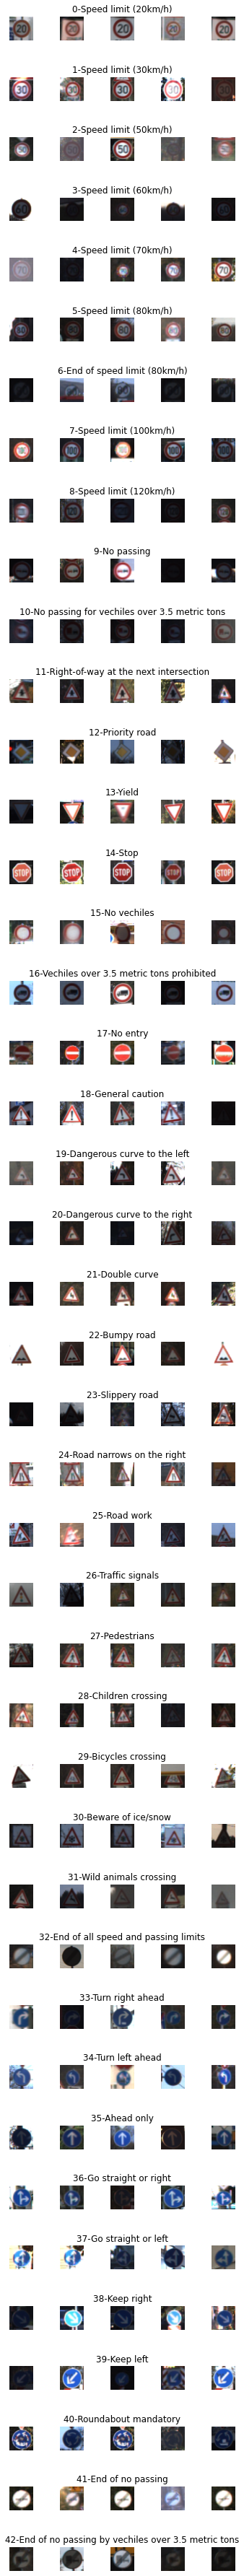

In [107]:
num_of_samples=[]


cols=5
num_classes=43

fig,axs=plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected=X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j)+"-"+row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


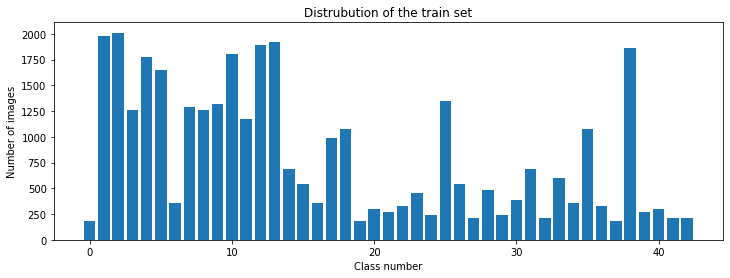

In [108]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distrubution of the train set")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()



In [109]:
import cv2

In [110]:
def cvrt_grayscale(img):
  img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  return img



(32, 32)


(-0.5, 31.5, 31.5, -0.5)

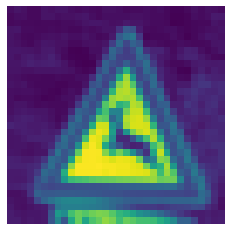

In [111]:

img=cvrt_grayscale(X_train[500])
print(img.shape)
plt.imshow(img);
plt.axis("off")

# Histogram Equalization
<li>This method usually increases the global contrast of many images, especially when the image is represented by a narrow range of intensity values. Through this adjustment, the intensities can be better distributed on the histogram utilizing the full range of intensities evenly. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the highly populated intensity values which are used to degrade image contrast.
<li>The method is useful in images with backgrounds and foregrounds that are both bright or both dark. In particular, the method can lead to better views of bone structure in x-ray images, and to better detail in photographs that are either over or under-exposed. A key advantage of the method is that it is a fairly straightforward technique adaptive to the input image and an invertible operator. So in theory, if the histogram equalization function is known, then the original histogram can be recovered. The calculation is not computationally intensive. A disadvantage of the method is that it is indiscriminate. It may increase the contrast of background noise, while decreasing the usable signal.

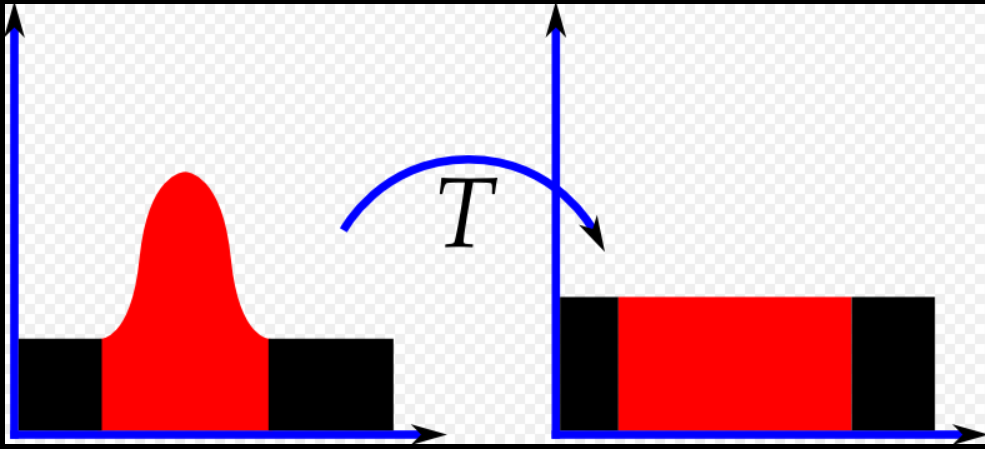

Text(0.5, 1.0, 'Equalized_image')

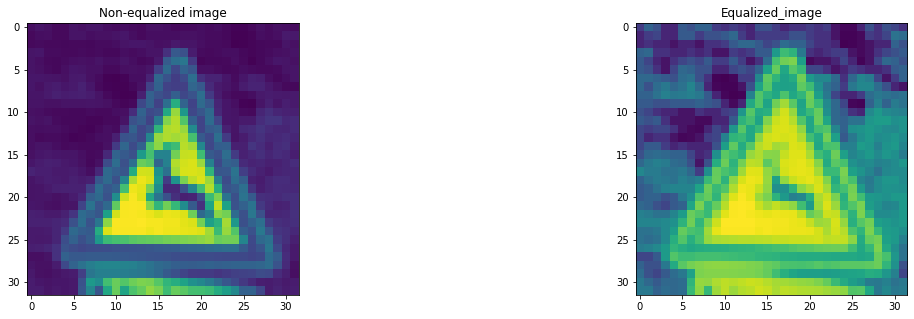

In [112]:
def equalize(img):
  img=cv2.equalizeHist(img)
  return img
figs,axs=plt.subplots(1,2,figsize=(20,5))
equalized_img=equalize(img)
axs[0].imshow(img)
axs[0].set_title("Non-equalized image")
axs[1].imshow(equalized_img)
axs[1].set_title("Equalized_image")

We can equalize our image using cv2.equalizeHist() method.

## Preprocessing
  Image preprocessing are the steps taken to format images before they are used by model training and inference. This includes, but it is not limited to, resizing,orienting and color corrections.

In [113]:
def preprocessing(img):
  grayscale_image=cvrt_grayscale(img)
  equalized_image=equalize(grayscale_image)
  normalized_image=equalized_image/255
  return equalized_image

Our preprocessing method will take image parameter. preprocessing method includes 3 steps. 
<li>First one is converting image to grayscale that we mentioned above. <li>After that equalizing image is most of the time provides to take better results from our classification model. 
<li>Lastly we normalized our image by reducing values between 0 and 1.Main purpose of normalization is to make computation efficent by reducing values between 0 and 1. 

In [114]:
X_train=np.array(list(map(preprocessing,X_train)))
X_val=np.array(list(map(preprocessing,X_val)))
X_test=np.array(list(map(preprocessing,X_test)))


We apply to our dataset preprocessing method which we declared above using map function. By the help of <b>map()</b> function we can apply to preprocessing method to every single image.We can observe that one of the preprocessed image from our dataset at the following lines.

(34799, 32, 32)


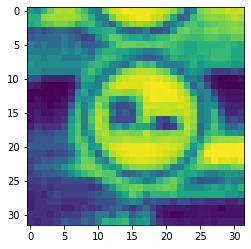

In [115]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
print(X_train.shape)

In [116]:
X_train=X_train.reshape(34799, 32, 32,1)
X_val=X_val.reshape(4410,32,32,1)
X_test=X_test.reshape(12630,32,32,1)

Our preprocessed images consist of grayscale images which have just one channel.Therefore we reshaped our images as single channel images. 

## Data Augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.It is closely related to oversampling in data analysis.

In our project we used that technique in order to prevent overfitting by applying  different operations like rotation,shifting,zooming etc.

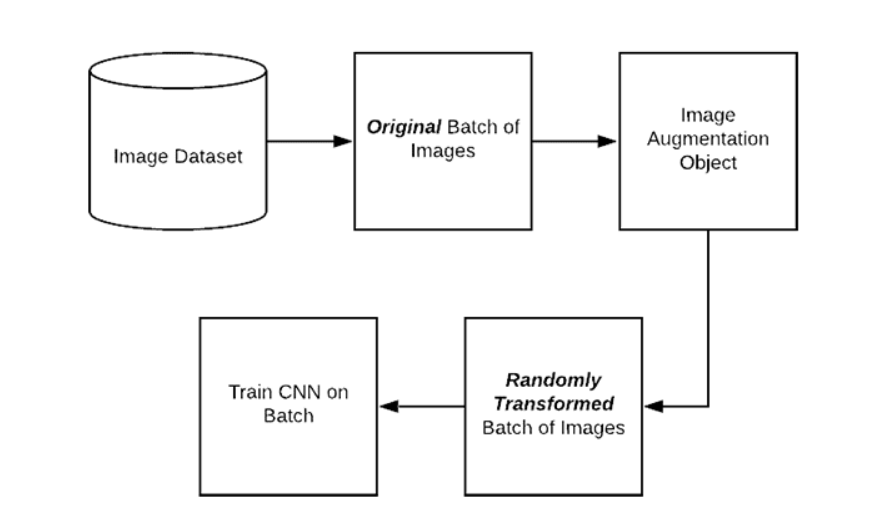


In [117]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=10,
                           zoom_range=0.2,
                           rotation_range=10
                           )
datagen.fit(X_train)#We apply augmentation on X_train

<b>ImageDataGenerator</b> is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.In our example it takes 5 arguments.<br>
<li><b>width_shift_range:</b> It actually shift the image to the left or right(horizontal shifts). If the value is float and <=1 it will take the percentage of total width as range. Suppose image width is 100px. if width_shift_range = 1.0 it will take -100% to +100% means -100px to +100px. It will shift image randomly between this range. Randomly selected positive value will shift the image to the right side and negative value will shift the image to the left side. We can also do this by selecting pixels. if we set width_shift_range = 100 it will have the same effect. More importantly integer value>=1 count pixel as range and float value<=1 count percentage of total width as range. Below images are for width_shift_range = 1.0.
<li><b>horizontal_shift_range:</b>It works same as width_shift_range but shift vertically(up or down). Below images are for height_shift_range=0.2,fill_mode="constant"
<li><b>rotation_range:</b>Int. Degree range for random rotations.
<li><b>zoom_range:</b>Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
<li><b>shear_range:</b>	Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)

## Visualizing Our Augmented Images

Augmented Images


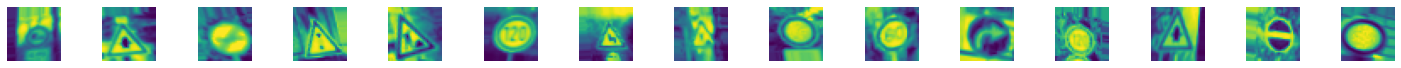

In [118]:
batches=datagen.flow(X_train,y_train,batch_size=15)
X_batch,y_batch=next(batches)
fig,axs,=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

print("Augmented Images")

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis("off")

Firstly we load our training dataset to batches with the help of flow() method. We're unpacking our 1 batch from batches using next() as X_batch and y_batch.For every single image we reshape our images as 32x32 and visualize using imshow method as above.

In [119]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [120]:
y_train=to_categorical(y_train,43)
y_val=to_categorical(y_val,43)
y_test=to_categorical(y_test,43)

We will apply the softmax activation function in the last layer of our neural network. Therefore we need to convert our y values to categorical values using to_categorical method.

## Model Implementation

In [121]:
def modified_model():
  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = (32,32,1)))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
#Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [122]:
model = modified_model()
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 64)          36928     
                                                      

In [123]:
eps = 30
anc = model.fit(X_train, y_train, batch_size=128, epochs=eps, validation_data=(X_val, y_val))

Epoch 1/30
272/272 [==============================] - 3s 10ms/step - loss: 2.5722 - accuracy: 0.4025 - val_loss: 0.6508 - val_accuracy: 0.8438
Epoch 2/30
272/272 [==============================] - 3s 10ms/step - loss: 0.8046 - accuracy: 0.7570 - val_loss: 0.3568 - val_accuracy: 0.8961
Epoch 3/30
272/272 [==============================] - 3s 10ms/step - loss: 0.5320 - accuracy: 0.8369 - val_loss: 0.2433 - val_accuracy: 0.9277
Epoch 4/30
272/272 [==============================] - 3s 12ms/step - loss: 0.4067 - accuracy: 0.8745 - val_loss: 0.1912 - val_accuracy: 0.9492
Epoch 5/30
272/272 [==============================] - 3s 13ms/step - loss: 0.3440 - accuracy: 0.8937 - val_loss: 0.1525 - val_accuracy: 0.9533
Epoch 6/30
272/272 [==============================] - 3s 12ms/step - loss: 0.2883 - accuracy: 0.9097 - val_loss: 0.1395 - val_accuracy: 0.9585
Epoch 7/30
272/272 [==============================] - 3s 13ms/step - loss: 0.2556 - accuracy: 0.9207 - val_loss: 0.1187 - val_accuracy: 0.9667

Text(0, 0.5, 'Loss')

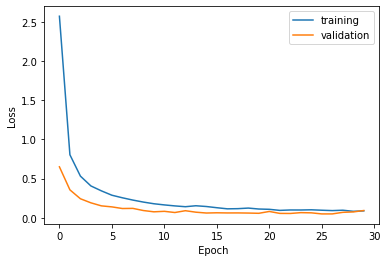

In [131]:
plt.plot(anc.history["loss"])
plt.plot(anc.history["val_loss"])
plt.legend(['training','validation'])
plt.xlabel(" Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

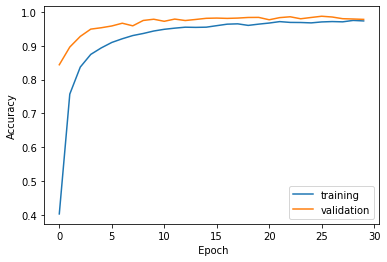

In [132]:
plt.plot(anc.history['accuracy'])
plt.plot(anc.history["val_accuracy"])
plt.legend(['training','validation'])
plt.xlabel(" Epoch")
plt.ylabel("Accuracy")

In [133]:
model.evaluate(X_test,y_test)

395/395 [==============================] - 2s 6ms/step - loss: 0.1484 - accuracy: 0.9624


[0.14835239946842194, 0.9623911380767822]

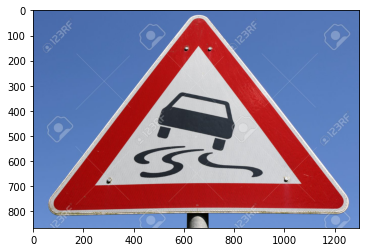

In [134]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


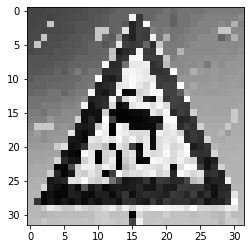

In [135]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [136]:
img = img.reshape(1, 32, 32, 1)

In [137]:
predicted_image=model.predict(img)
predicted_class=np.argmax(predicted_image,axis=1)
print("predicted sign: "+ str(predicted_class))

1/1 [==============================] - 0s 18ms/step
predicted sign: [23]
